In [80]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPooling2D,Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
!pip install plotly

In [81]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

In [82]:
def create_model():
   
    model = Sequential()

    #1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(28,28,3), kernel_size=(11,11), strides=(4,4), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(28,28,3,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))

    #2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #Add Dropout
    model.add(Dropout(0.4))

    #3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #Add Dropout
    model.add(Dropout(0.4))

    #Output Layer
    model.add(Dense(7))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model;

In [83]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

In [84]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

In [85]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

In [86]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [87]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)

In [88]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"E:\input", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [89]:
data = pd.read_csv(os.path.join(base_skin_dir,'E:/input','E:/HAM00001/HAM10000_metadata.csv'))

In [90]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [91]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,dataset
count,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,4
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,vidir_molemax
freq,6,1,6705,5340,5406,2192,3954


In [92]:
data.isnull().any().sum()

1

In [93]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [94]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [95]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_2\ISIC_0031633.jpg


In [96]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [97]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0027419.jpg,"[[[192, 153, 193], [195, 155, 192], [197, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0025030.jpg,"[[[27, 16, 32], [69, 49, 76], [122, 93, 126], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0026769.jpg,"[[[192, 138, 153], [200, 144, 162], [202, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_1\ISIC_0025661.jpg,"[[[40, 21, 31], [95, 61, 73], [143, 102, 118],..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),E:\input\HAM10000_images_part_2\ISIC_0031633.jpg,"[[[159, 114, 140], [194, 144, 173], [215, 162,..."


In [98]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [99]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [100]:
len(frames)

7

In [101]:
final_data = pd.concat(frames)

In [102]:
print(data.shape)
print(final_data.shape)

(10015, 13)
(45756, 13)


In [103]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [104]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [105]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [106]:
model =create_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 7, 7, 96)          34944     
                                                                 
 batch_normalization_18 (Bat  (None, 7, 7, 96)         384       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 7, 7, 96)          0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 96)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 256)         614656    
                                                                 
 batch_normalization_19 (Bat  (None, 4, 4, 256)       

In [107]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [108]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 346s 747ms/step - loss: 1.1320 - accuracy: 0.5951 - val_loss: 2.6876 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 2/50
458/458 [==============================] - 347s 758ms/step - loss: 0.8069 - accuracy: 0.7260 - val_loss: 1.9822 - val_accuracy: 0.3139 - lr: 0.0010
Epoch 3/50
458/458 [==============================] - 346s 756ms/step - loss: 0.6519 - accuracy: 0.7782 - val_loss: 2.6293 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 4/50
458/458 [==============================] - 345s 753ms/step - loss: 0.5471 - accuracy: 0.8140 - val_loss: 1.5854 - val_accuracy: 0.4499 - lr: 0.0010
Epoch 5/50
458/458 [==============================] - 362s 790ms/step - loss: 0.4740 - accuracy: 0.8357 - val_loss: 1.5871 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 6/50
458/458 [==============================] - 358s 782ms/step - loss: 0.4177 - accuracy: 0.8559 - val_loss: 2.6994 - val_accuracy: 0.2079 - lr: 0.0010
Epoch 7/50
458/458 [==========================

In [111]:
model.save_weights("Skin_Cancer_alexnetnadam.hdf5")


In [112]:
from IPython.display import FileLink
FileLink('Skin_Cancer_alexnetnadam.hdf5')

C:\Users\Lenovo\Skin_Cancer_alexnetnadam.hdf5

In [113]:
plot_model_training_curve(model2_history)

Test Accuracy: 96.605%
              precision    recall  f1-score   support

          nv       1.00      0.95      0.98      1374
         mel       0.89      0.99      0.94       205
         bkl       0.87      1.00      0.93       227
         bcc       0.95      1.00      0.97        94
       akiec       0.95      1.00      0.97        55
        vasc       0.97      1.00      0.98        28
          df       0.95      1.00      0.98        20

    accuracy                           0.97      2003
   macro avg       0.94      0.99      0.96      2003
weighted avg       0.97      0.97      0.97      2003



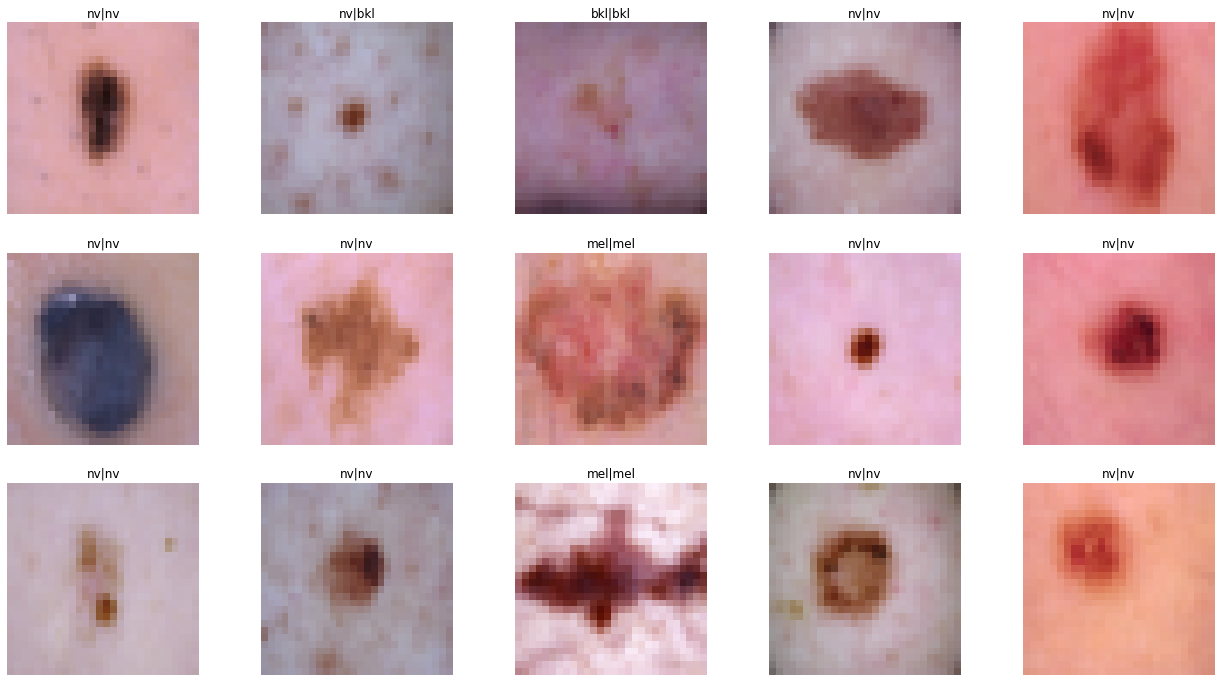

In [114]:
test_model(model, X_test_orig, Y_test_orig)

In [115]:
y_true = np.array(Y_test_orig)
y_pred = model.predict(X_test_orig)

In [116]:
y_true

array([[0],
       [0],
       [2],
       ...,
       [1],
       [0],
       [1]], dtype=int64)

In [117]:
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

In [118]:
y_pred

array([0, 2, 2, ..., 1, 0, 1], dtype=int64)

In [119]:
cm=confusion_matrix(y_true, y_pred)
print(cm)

[[1308   25   31    5    3    1    1]
 [   0  203    2    0    0    0    0]
 [   0    0  227    0    0    0    0]
 [   0    0    0   94    0    0    0]
 [   0    0    0    0   55    0    0]
 [   0    0    0    0    0   28    0]
 [   0    0    0    0    0    0   20]]


<AxesSubplot:>

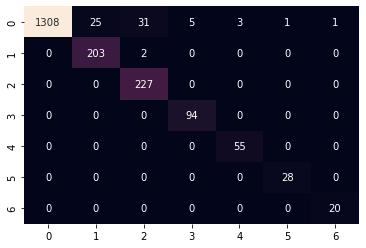

In [120]:
sns.heatmap(cm,annot = True,cbar=False,fmt='d')